In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [2]:
class DataSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.N = batch_size
        self.labels = labels

    def __iter__(self):
        num_yielded = 0
        while num_yielded < self.labels.size()[0]:
            batch = torch.randint(high=self.labels.size()[0], size=(self.N,)).long()
            num_yielded += self.N
            yield batch

In [3]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_sampler=DataSampler(batch_size=batch_size, num_classes=num_classes, labels=train_dataset.train_labels), 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                         batch_sampler=DataSampler(batch_size=batch_size, num_classes=num_classes, labels=test_dataset.test_labels), 
                                         shuffle=False)

torch.Size([1, 28, 28])


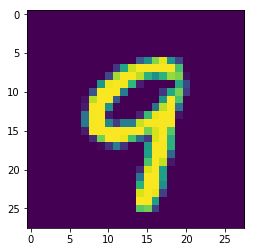

In [4]:
x = next(iter(train_loader))
print( x[0][0].shape )
plt.imshow(x[0][0].reshape(28, 28) )

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            Flatten(),
            nn.Linear(1024, 8),
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output

In [6]:
class DeFlatten(nn.Module):
    def forward(self, x):
        return x.view( -1, 1024, 7, 7 )

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Linear(8, 7 * 7 * 1024),
            nn.ReLU(),
            DeFlatten(),
            nn.ConvTranspose2d(1024, 512, 4),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output

In [7]:
def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int):
    batch_size = X.size(0)

    p2_norm_x = X.pow(2).sum(1).unsqueeze(0)
    norms_x = X.sum(1).unsqueeze(0)
    prods_x = torch.mm(norms_x, norms_x.t())
    dists_x = p2_norm_x + p2_norm_x.t() - 2 * prods_x

    p2_norm_y = Y.pow(2).sum(1).unsqueeze(0)
    norms_y = X.sum(1).unsqueeze(0)
    prods_y = torch.mm(norms_y, norms_y.t())
    dists_y = p2_norm_y + p2_norm_y.t() - 2 * prods_y

    dot_prd = torch.mm(norms_x, norms_y.t())
    dists_c = p2_norm_x + p2_norm_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).cuda()) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats

In [8]:
encoder, decoder = Encoder(), Decoder()
encoder.train()
decoder.train()

opt_e = torch.optim.Adam( encoder.parameters(), lr=0.0005 )
opt_d = torch.optim.Adam( decoder.parameters(), lr=0.0005 )

mse = MSELoss()

for epoch in range(50):
    for data, target in tqdm(train_loader):
        opt_e.zero_grad()
        opt_d.zero_grad()

        z = encoder(data)
        x = decoder(z)

        z_f = torch.randn(data.size()[0], 8)

        mmd_loss = imq_kernel(z, z_f, h_dim=8)
        mmd_loss = mmd_loss.mean()

        loss = mse(data, x) - mmd_loss
        loss.backward()

        opt_e.step()
        opt_d.step()
        
        print(loss.data)

1it [00:31, 31.11s/it]

tensor(48249.9297)


KeyboardInterrupt: 